# train

In [1]:
import yaml
import os

with open("./config.yaml", 'rb') as f:
    config = yaml.load(f)

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


In [2]:
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
os.makedirs(OUTPUT_ROOT, exist_ok=True)

## load library

In [3]:
# python default library
import os
import shutil
import datetime
import sys
import pickle

# general analysis tool-kit
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim, nn
from torch.utils.tensorboard import SummaryWriter

from torchsummary import summary

# etc
import yaml
yaml.warnings({'YAMLLoadWarning': False})
import mlflow
from collections import defaultdict
from scipy.stats import zscore

# original library

import common as com
import pytorch_modeler as modeler
from pytorch_model import LSTM_AutoEncoder as Model
from pytorch_utils import filtered_load_model
import models

import librosa
import IPython
import librosa.display

## load config and set logger

In [4]:
#with open("./config.yaml", 'rb') as f:
#    config = yaml.load(f)

log_folder = config['IO_OPTION']['OUTPUT_ROOT']+'/{0}.log'.format(datetime.date.today())
logger = com.setup_logger(log_folder, '00_train.py')

/home/hiroki/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Setting

In [5]:
# Setting seed
modeler.set_seed(42)

In [6]:
############################################################################
# Setting I/O path
############################################################################
# input dirs
INPUT_ROOT = config['IO_OPTION']['INPUT_ROOT']
dev_path = INPUT_ROOT + "/dev_data"
add_dev_path = INPUT_ROOT + "/add_dev_data"
# machine type
MACHINE_TYPE = config['IO_OPTION']['MACHINE_TYPE']
machine_types = os.listdir(dev_path)
# output dirs
OUTPUT_ROOT = config['IO_OPTION']['OUTPUT_ROOT']
MODEL_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/models'
TB_DIR = config['IO_OPTION']['OUTPUT_ROOT'] + '/tb'
PKL_DIR = OUTPUT_ROOT + '/pkl'
#os.makedirs(OUTPUT_ROOT, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(TB_DIR, exist_ok=True)
os.makedirs(PKL_DIR, exist_ok=True)
# copy config
shutil.copy('./config.yaml', OUTPUT_ROOT)

'/media/hiroki/working/research/dcase2020/result/2D/seq2seq/config.yaml'

## make path list and train/valid split

In [7]:
############################################################################
# make path set and train/valid split
############################################################################
'''
train_paths[machine_type]['train' or 'valid'] = path
'''
dev_train_paths = {}
add_train_paths = {}
train_paths = {}

In [8]:
for machine_type in machine_types:
    # dev train
    dev_train_paths = ["{}/{}/train/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(dev_path, machine_type))]
    dev_train_paths = sorted(dev_train_paths)
    # add_dev train
    add_train_paths = ["{}/{}/train/".format(add_dev_path, machine_type) + file for file in os.listdir("{}/{}/train".format(add_dev_path, machine_type))]
    add_train_paths = sorted(add_train_paths)
    # valid
    dev_valid_paths = ["{}/{}/test/".format(dev_path, machine_type) + file for file in os.listdir("{}/{}/test".format(dev_path, machine_type))]
    dev_valid_paths = sorted(dev_valid_paths)
    
    train_paths[machine_type] = {}
    train_paths[machine_type]['train'] = dev_train_paths + add_train_paths
    train_paths[machine_type]['valid'] = dev_valid_paths

## training

In [9]:
#############################################################################
# run
#############################################################################
def run(machine_type):
    com.tic()
    logger.info('TARGET MACHINE_TYPE: {0}'.format(machine_type))
    logger.info('MAKE DATA_LOADER')
    # dev_train_paths
    dataloaders_dict = modeler.make_dataloader(train_paths, machine_type)
    # define writer for tensorbord
    os.makedirs(TB_DIR+'/'+machine_type, exist_ok=True)         # debug
    tb_log_dir = TB_DIR + '/' + machine_type
    writer = SummaryWriter(log_dir = tb_log_dir)
    logger.info('TRAINING')
    # parameter setting
    net = Model(sample_rate=config['preprocessing']['sample_rate'],
                window_size=config['preprocessing']['window_size'],
                hop_size=config['preprocessing']['hop_size'],
                mel_bins=config['preprocessing']['mel_bins'],
                fmin=config['preprocessing']['fmin'],
                fmax=config['preprocessing']['fmax'])
    #pretrained_dict = torch.load(config['IO_OPTION']['PREMODEL_PATH'])
    #net = filtered_load_model(net, pretrained_dict)
    optimizer = optim.Adam(net.parameters(), lr=1e-2)
    criterion = nn.MSELoss()
    num_epochs = config['fit']['num_epochs']
    history = modeler.train_net(net, dataloaders_dict, criterion, optimizer, num_epochs, writer)
    # output
    model = history['model']
    model_out_path = MODEL_DIR+'/{}_model.pth'.format(machine_type)
    torch.save(model.state_dict(), model_out_path)
    logger.info('\n success:{0} \n'.format(machine_type) + \
                    'model_out_path ==> \n {0}'.format(model_out_path))
    #  close writer for tensorbord
    writer.close()
    #modeler.mlflow_log(history, config, machine_type, model_out_path, tb_log_dir)
    com.toc()
    return history

In [10]:
machine_types

['fan', 'pump', 'slider', 'ToyCar', 'ToyConveyor', 'valve']

2020-11-06 11:58:58,681 - 00_train.py - INFO - TARGET MACHINE_TYPE: fan
2020-11-06 11:58:58,681 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-06 11:58:59,574 - 00_train.py - INFO - TRAINING


use: cuda:0


100%|██████████| 1803/1803 [00:10<00:00, 171.96it/s]


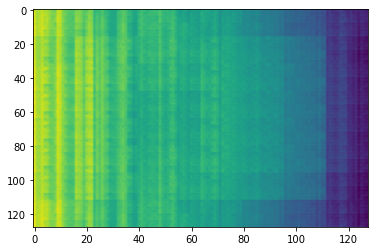

2020-11-06 12:00:01,388 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:931.936214, valid_AUC:0.519156, valid_pAUC:0.502635
100%|██████████| 1803/1803 [00:10<00:00, 169.42it/s]
2020-11-06 12:01:01,396 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:858.275666, valid_AUC:0.523553, valid_pAUC:0.502626
100%|██████████| 1803/1803 [00:10<00:00, 166.19it/s]
2020-11-06 12:02:02,463 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:792.742757, valid_AUC:0.521139, valid_pAUC:0.502213
100%|██████████| 1803/1803 [00:10<00:00, 168.61it/s]
2020-11-06 12:03:02,795 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:732.624717, valid_AUC:0.518526, valid_pAUC:0.502560
100%|██████████| 1803/1803 [00:10<00:00, 167.64it/s]
2020-11-06 12:04:03,224 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:677.353847, valid_AUC:0.523865, valid_pAUC:0.503217
100%|██████████| 1803/1803 [00:10<00:00, 168.94it/s]
2020-11-06 12:05:03,495 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:626.289793, v

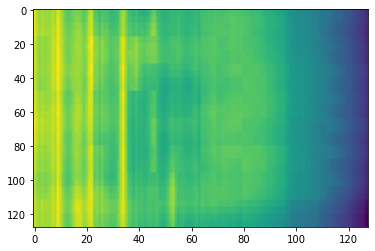

2020-11-06 12:09:04,044 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:455.629669, valid_AUC:0.527375, valid_pAUC:0.507681
100%|██████████| 1803/1803 [00:10<00:00, 172.29it/s]
2020-11-06 12:10:03,803 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:419.612864, valid_AUC:0.506401, valid_pAUC:0.503357
100%|██████████| 1803/1803 [00:10<00:00, 168.80it/s]
2020-11-06 12:11:04,292 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:385.902411, valid_AUC:0.530414, valid_pAUC:0.505017
100%|██████████| 1803/1803 [00:10<00:00, 168.94it/s]
2020-11-06 12:12:04,576 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:354.250364, valid_AUC:0.531234, valid_pAUC:0.508201
100%|██████████| 1803/1803 [00:10<00:00, 168.75it/s]
2020-11-06 12:13:04,826 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:324.589633, valid_AUC:0.527583, valid_pAUC:0.503611
100%|██████████| 1803/1803 [00:10<00:00, 168.67it/s]
2020-11-06 12:14:05,204 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:296.793

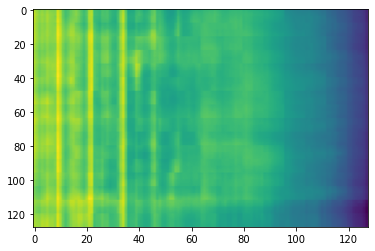

2020-11-06 12:19:05,169 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:183.215393, valid_AUC:0.517823, valid_pAUC:0.504914
100%|██████████| 1803/1803 [00:10<00:00, 172.65it/s]
2020-11-06 12:20:04,865 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:165.073342, valid_AUC:0.536842, valid_pAUC:0.508994
100%|██████████| 1803/1803 [00:10<00:00, 172.06it/s]
2020-11-06 12:21:04,534 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:148.359935, valid_AUC:0.508199, valid_pAUC:0.505937
100%|██████████| 1803/1803 [00:10<00:00, 172.60it/s]
2020-11-06 12:22:04,223 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:132.927722, valid_AUC:0.538845, valid_pAUC:0.511432
100%|██████████| 1803/1803 [00:10<00:00, 172.43it/s]
2020-11-06 12:23:03,885 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:118.726446, valid_AUC:0.519498, valid_pAUC:0.506171
100%|██████████| 1803/1803 [00:10<00:00, 171.77it/s]
2020-11-06 12:24:03,582 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:105.783

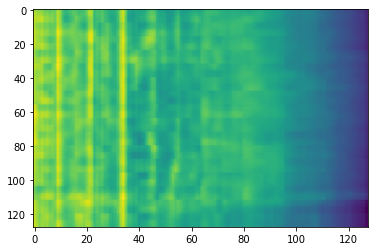

2020-11-06 12:29:01,999 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:56.780316, valid_AUC:0.585069, valid_pAUC:0.505646
100%|██████████| 1803/1803 [00:10<00:00, 171.99it/s]
2020-11-06 12:30:01,680 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:49.717293, valid_AUC:0.596848, valid_pAUC:0.510382
100%|██████████| 1803/1803 [00:10<00:00, 172.92it/s]
2020-11-06 12:31:01,310 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:43.439324, valid_AUC:0.510077, valid_pAUC:0.518532
100%|██████████| 1803/1803 [00:10<00:00, 172.79it/s]
2020-11-06 12:32:00,990 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:37.913934, valid_AUC:0.574821, valid_pAUC:0.509725
100%|██████████| 1803/1803 [00:10<00:00, 172.48it/s]
2020-11-06 12:33:00,643 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:33.058137, valid_AUC:0.595351, valid_pAUC:0.513505
100%|██████████| 1803/1803 [00:10<00:00, 172.92it/s]
2020-11-06 12:34:00,301 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:28.824783, v

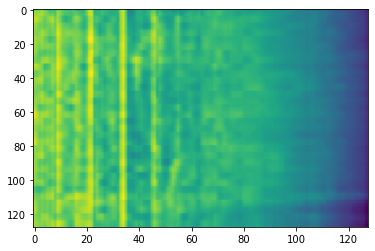

2020-11-06 12:38:58,662 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:15.117473, valid_AUC:0.599266, valid_pAUC:0.509425
100%|██████████| 1803/1803 [00:10<00:00, 172.77it/s]
2020-11-06 12:39:58,288 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:13.535238, valid_AUC:0.601853, valid_pAUC:0.514902
100%|██████████| 1803/1803 [00:10<00:00, 172.28it/s]
2020-11-06 12:40:57,958 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:12.215690, valid_AUC:0.573407, valid_pAUC:0.513674
100%|██████████| 1803/1803 [00:10<00:00, 172.79it/s]
2020-11-06 12:41:57,628 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:11.131828, valid_AUC:0.590984, valid_pAUC:0.512773
100%|██████████| 1803/1803 [00:10<00:00, 172.50it/s]
2020-11-06 12:42:57,306 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:10.310633, valid_AUC:0.606315, valid_pAUC:0.509322
100%|██████████| 1803/1803 [00:10<00:00, 172.96it/s]
2020-11-06 12:43:56,916 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:9.584420, va

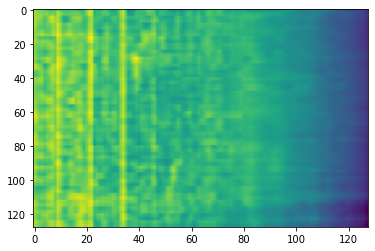

2020-11-06 12:48:55,092 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:7.742175, valid_AUC:0.601087, valid_pAUC:0.513552
100%|██████████| 1803/1803 [00:10<00:00, 172.63it/s]
2020-11-06 12:49:54,759 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:7.539948, valid_AUC:0.610907, valid_pAUC:0.511957
100%|██████████| 1803/1803 [00:10<00:00, 172.65it/s]
2020-11-06 12:50:54,398 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:7.439170, valid_AUC:0.579901, valid_pAUC:0.509707
100%|██████████| 1803/1803 [00:10<00:00, 172.78it/s]
2020-11-06 12:51:54,040 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:7.312164, valid_AUC:0.603689, valid_pAUC:0.511235
100%|██████████| 1803/1803 [00:10<00:00, 172.75it/s]
2020-11-06 12:52:53,741 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:7.217867, valid_AUC:0.590953, valid_pAUC:0.508985
100%|██████████| 1803/1803 [00:10<00:00, 172.23it/s]
2020-11-06 12:53:53,500 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:7.132219, valid_A

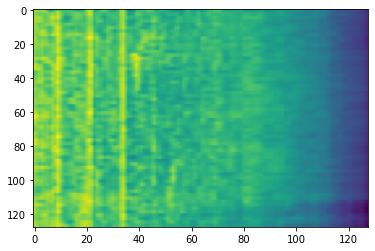

2020-11-06 12:58:52,244 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:6.849395, valid_AUC:0.597604, valid_pAUC:0.512539
100%|██████████| 1803/1803 [00:10<00:00, 170.34it/s]
2020-11-06 12:59:52,031 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:6.750182, valid_AUC:0.600282, valid_pAUC:0.510963
100%|██████████| 1803/1803 [00:10<00:00, 172.34it/s]
2020-11-06 13:00:51,721 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:6.711126, valid_AUC:0.600691, valid_pAUC:0.508178
100%|██████████| 1803/1803 [00:10<00:00, 170.72it/s]
2020-11-06 13:01:51,543 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:6.647935, valid_AUC:0.594507, valid_pAUC:0.511564
100%|██████████| 1803/1803 [00:10<00:00, 172.33it/s]
2020-11-06 13:02:51,233 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:6.583437, valid_AUC:0.593703, valid_pAUC:0.512145
100%|██████████| 1803/1803 [00:10<00:00, 171.24it/s]
2020-11-06 13:03:50,990 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:6.552833, valid_A

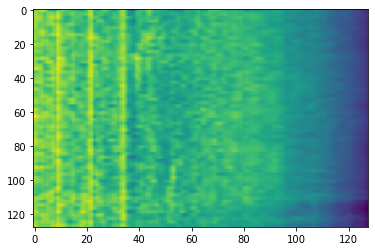

2020-11-06 13:08:49,752 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:6.360628, valid_AUC:0.603431, valid_pAUC:0.512726
100%|██████████| 1803/1803 [00:10<00:00, 170.47it/s]
2020-11-06 13:09:49,592 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:6.278972, valid_AUC:0.584808, valid_pAUC:0.513514
100%|██████████| 1803/1803 [00:10<00:00, 172.47it/s]
2020-11-06 13:10:49,291 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:6.334946, valid_AUC:0.584898, valid_pAUC:0.511573
100%|██████████| 1803/1803 [00:10<00:00, 171.18it/s]
2020-11-06 13:11:49,073 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:6.285559, valid_AUC:0.562736, valid_pAUC:0.508037
100%|██████████| 1803/1803 [00:10<00:00, 172.11it/s]
2020-11-06 13:12:48,785 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:6.222873, valid_AUC:0.592985, valid_pAUC:0.513889
100%|██████████| 1803/1803 [00:10<00:00, 170.70it/s]
2020-11-06 13:13:48,584 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:6.199789, valid_A

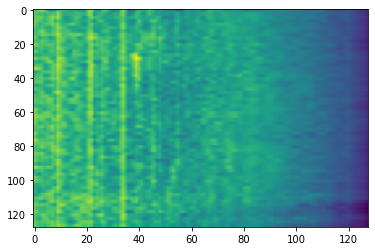

2020-11-06 13:18:47,236 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:6.083064, valid_AUC:0.608389, valid_pAUC:0.511498
100%|██████████| 1803/1803 [00:10<00:00, 170.41it/s]
2020-11-06 13:19:47,038 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:6.030427, valid_AUC:0.598967, valid_pAUC:0.511929
100%|██████████| 1803/1803 [00:10<00:00, 172.38it/s]
2020-11-06 13:20:46,721 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:6.017471, valid_AUC:0.597420, valid_pAUC:0.513852
100%|██████████| 1803/1803 [00:10<00:00, 170.73it/s]
2020-11-06 13:21:46,491 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:6.003509, valid_AUC:0.594877, valid_pAUC:0.512464
100%|██████████| 1803/1803 [00:10<00:00, 172.59it/s]
2020-11-06 13:22:46,125 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:6.028127, valid_AUC:0.603917, valid_pAUC:0.508638
100%|██████████| 1803/1803 [00:10<00:00, 170.15it/s]
2020-11-06 13:23:45,913 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:5.983891, valid_A

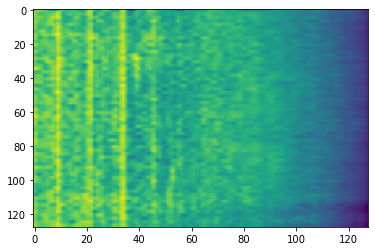

2020-11-06 13:28:44,607 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:5.870096, valid_AUC:0.608035, valid_pAUC:0.510091
100%|██████████| 1803/1803 [00:10<00:00, 170.29it/s]
2020-11-06 13:29:44,408 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:5.856867, valid_AUC:0.598737, valid_pAUC:0.513861
100%|██████████| 1803/1803 [00:10<00:00, 172.22it/s]
2020-11-06 13:30:44,111 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:5.871660, valid_AUC:0.618981, valid_pAUC:0.512333
100%|██████████| 1803/1803 [00:10<00:00, 170.90it/s]
2020-11-06 13:31:43,875 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:5.792145, valid_AUC:0.600485, valid_pAUC:0.515474
100%|██████████| 1803/1803 [00:10<00:00, 172.24it/s]
2020-11-06 13:32:43,614 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:5.801800, valid_AUC:0.606027, valid_pAUC:0.514949
100%|██████████| 1803/1803 [00:10<00:00, 170.69it/s]
2020-11-06 13:33:43,371 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:5.801786, valid_A

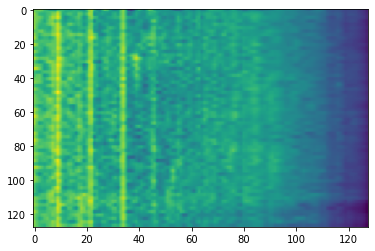

2020-11-06 13:38:42,105 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:5.736646, valid_AUC:0.594050, valid_pAUC:0.511376
2020-11-06 13:38:42,232 - 00_train.py - INFO - 
 success:fan 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/seq2seq/models/fan_model.pth


elapsed time: 5983.552219629 [sec]


2020-11-06 13:38:42,458 - 00_train.py - INFO - TARGET MACHINE_TYPE: pump
2020-11-06 13:38:42,459 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-06 13:38:42,460 - 00_train.py - INFO - TRAINING
  0%|          | 0/91 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 832/832 [00:08<00:00, 97.37it/s] 


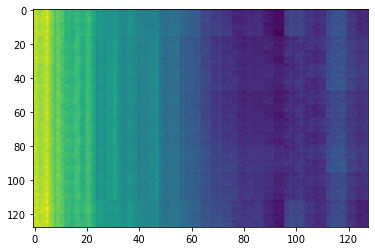

2020-11-06 13:40:28,474 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:934.242796, valid_AUC:0.299659, valid_pAUC:0.487573
100%|██████████| 832/832 [00:04<00:00, 172.46it/s]
2020-11-06 13:41:16,600 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:869.935710, valid_AUC:0.306476, valid_pAUC:0.487634
100%|██████████| 832/832 [00:04<00:00, 170.94it/s]
2020-11-06 13:42:04,915 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:810.507095, valid_AUC:0.301354, valid_pAUC:0.487147
100%|██████████| 832/832 [00:04<00:00, 172.40it/s]
2020-11-06 13:42:53,195 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:755.625287, valid_AUC:0.301458, valid_pAUC:0.487939
100%|██████████| 832/832 [00:04<00:00, 173.26it/s]
2020-11-06 13:43:41,499 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:705.499365, valid_AUC:0.302494, valid_pAUC:0.487634
100%|██████████| 832/832 [00:04<00:00, 172.82it/s]
2020-11-06 13:44:29,853 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:659.041433, valid_AUC:0

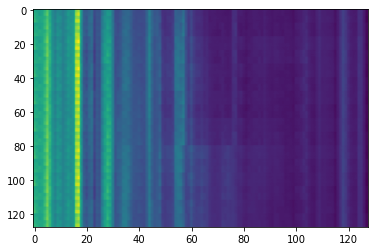

2020-11-06 13:47:43,658 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:498.674033, valid_AUC:0.341719, valid_pAUC:0.494974
100%|██████████| 832/832 [00:04<00:00, 172.48it/s]
2020-11-06 13:48:31,996 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:464.608131, valid_AUC:0.306690, valid_pAUC:0.484771
100%|██████████| 832/832 [00:04<00:00, 171.58it/s]
2020-11-06 13:49:20,366 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:432.003265, valid_AUC:0.282917, valid_pAUC:0.486202
100%|██████████| 832/832 [00:04<00:00, 172.15it/s]
2020-11-06 13:50:08,709 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:400.953258, valid_AUC:0.494624, valid_pAUC:0.509320
100%|██████████| 832/832 [00:04<00:00, 172.37it/s]
2020-11-06 13:50:57,048 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:371.415559, valid_AUC:0.274444, valid_pAUC:0.487756
100%|██████████| 832/832 [00:04<00:00, 167.69it/s]
2020-11-06 13:51:45,517 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:344.468288, valid

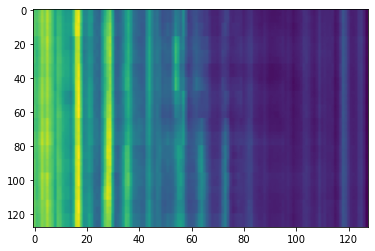

2020-11-06 13:55:47,456 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:228.477226, valid_AUC:0.580914, valid_pAUC:0.515168
100%|██████████| 832/832 [00:04<00:00, 172.32it/s]
2020-11-06 13:56:35,843 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:210.252027, valid_AUC:0.431389, valid_pAUC:0.502894
100%|██████████| 832/832 [00:04<00:00, 172.80it/s]
2020-11-06 13:57:24,193 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:191.290985, valid_AUC:0.345064, valid_pAUC:0.488030
100%|██████████| 832/832 [00:04<00:00, 172.30it/s]
2020-11-06 13:58:12,562 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:175.234973, valid_AUC:0.614508, valid_pAUC:0.544286
100%|██████████| 832/832 [00:04<00:00, 172.28it/s]
2020-11-06 13:59:00,930 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:159.916938, valid_AUC:0.317772, valid_pAUC:0.490406
100%|██████████| 832/832 [00:04<00:00, 172.14it/s]
2020-11-06 13:59:49,296 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:144.723016, valid

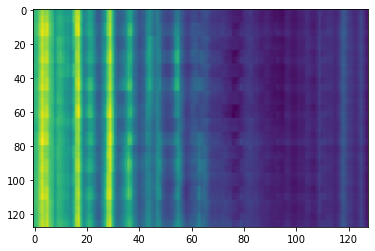

2020-11-06 14:03:51,322 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:87.027365, valid_AUC:0.716875, valid_pAUC:0.596826
100%|██████████| 832/832 [00:04<00:00, 172.41it/s]
2020-11-06 14:04:39,667 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:78.119411, valid_AUC:0.544225, valid_pAUC:0.508985
100%|██████████| 832/832 [00:04<00:00, 171.55it/s]
2020-11-06 14:05:28,055 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:69.685920, valid_AUC:0.696279, valid_pAUC:0.570967
100%|██████████| 832/832 [00:04<00:00, 172.32it/s]
2020-11-06 14:06:16,398 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:62.367762, valid_AUC:0.669225, valid_pAUC:0.555007
100%|██████████| 832/832 [00:04<00:00, 171.86it/s]
2020-11-06 14:07:04,764 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:55.398819, valid_AUC:0.478472, valid_pAUC:0.489797
100%|██████████| 832/832 [00:04<00:00, 171.96it/s]
2020-11-06 14:07:53,168 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:49.235077, valid_AUC:0

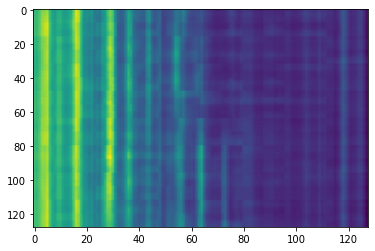

2020-11-06 14:11:55,316 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:28.488307, valid_AUC:0.494948, valid_pAUC:0.485167
100%|██████████| 832/832 [00:04<00:00, 171.34it/s]
2020-11-06 14:12:43,709 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:24.623286, valid_AUC:0.548709, valid_pAUC:0.486659
100%|██████████| 832/832 [00:04<00:00, 171.36it/s]
2020-11-06 14:13:32,110 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:21.813997, valid_AUC:0.676655, valid_pAUC:0.549342
100%|██████████| 832/832 [00:04<00:00, 170.64it/s]
2020-11-06 14:14:20,480 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:19.544125, valid_AUC:0.643229, valid_pAUC:0.532194
100%|██████████| 832/832 [00:04<00:00, 171.27it/s]
2020-11-06 14:15:08,855 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:17.572141, valid_AUC:0.529062, valid_pAUC:0.494700
100%|██████████| 832/832 [00:04<00:00, 171.25it/s]
2020-11-06 14:15:57,221 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:15.881288, valid_AUC:0

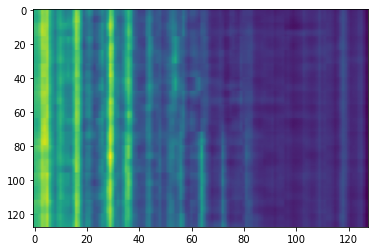

2020-11-06 14:19:59,106 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:10.765565, valid_AUC:0.702934, valid_pAUC:0.575567
100%|██████████| 832/832 [00:04<00:00, 170.95it/s]
2020-11-06 14:20:47,462 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:10.258195, valid_AUC:0.606487, valid_pAUC:0.504995
100%|██████████| 832/832 [00:04<00:00, 171.16it/s]
2020-11-06 14:21:35,838 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:9.816453, valid_AUC:0.639126, valid_pAUC:0.522265
100%|██████████| 832/832 [00:04<00:00, 171.22it/s]
2020-11-06 14:22:24,235 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:9.374162, valid_AUC:0.694896, valid_pAUC:0.579709
100%|██████████| 832/832 [00:04<00:00, 171.34it/s]
2020-11-06 14:23:12,604 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:9.101461, valid_AUC:0.624630, valid_pAUC:0.518275
100%|██████████| 832/832 [00:04<00:00, 170.69it/s]
2020-11-06 14:24:01,011 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:8.809290, valid_AUC:0.658

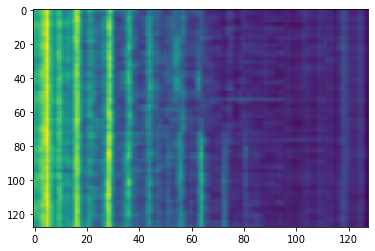

2020-11-06 14:28:02,994 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:8.072521, valid_AUC:0.657182, valid_pAUC:0.519219
100%|██████████| 832/832 [00:04<00:00, 170.82it/s]
2020-11-06 14:28:51,342 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:7.996643, valid_AUC:0.663304, valid_pAUC:0.528113
100%|██████████| 832/832 [00:04<00:00, 171.29it/s]
2020-11-06 14:29:39,705 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:7.894405, valid_AUC:0.661759, valid_pAUC:0.523910
100%|██████████| 832/832 [00:04<00:00, 171.09it/s]
2020-11-06 14:30:28,105 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:7.822694, valid_AUC:0.650828, valid_pAUC:0.542611
100%|██████████| 832/832 [00:04<00:00, 171.06it/s]
2020-11-06 14:31:16,508 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:7.768637, valid_AUC:0.636134, valid_pAUC:0.521290
100%|██████████| 832/832 [00:04<00:00, 171.01it/s]
2020-11-06 14:32:04,925 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:7.664844, valid_AUC:0.66140

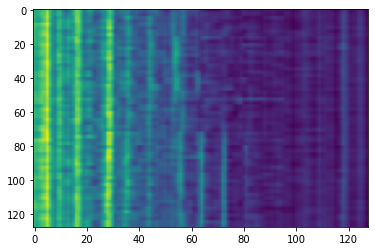

2020-11-06 14:36:07,032 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:7.472807, valid_AUC:0.660683, valid_pAUC:0.540144
100%|██████████| 832/832 [00:04<00:00, 171.93it/s]
2020-11-06 14:36:55,388 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:8.455778, valid_AUC:0.668533, valid_pAUC:0.603953
100%|██████████| 832/832 [00:04<00:00, 166.75it/s]
2020-11-06 14:37:43,938 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:13.250739, valid_AUC:0.650168, valid_pAUC:0.555495
100%|██████████| 832/832 [00:04<00:00, 171.79it/s]
2020-11-06 14:38:32,311 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:11.188023, valid_AUC:0.657321, valid_pAUC:0.547058
100%|██████████| 832/832 [00:04<00:00, 171.08it/s]
2020-11-06 14:39:20,730 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:10.454839, valid_AUC:0.665613, valid_pAUC:0.549647
100%|██████████| 832/832 [00:04<00:00, 170.69it/s]
2020-11-06 14:40:09,219 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.103830, valid_AUC:0.6

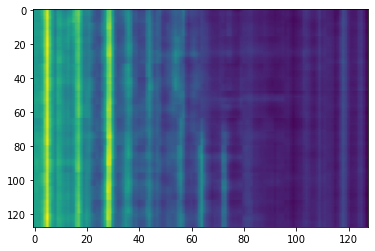

2020-11-06 14:44:11,487 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:9.260293, valid_AUC:0.678958, valid_pAUC:0.599811
100%|██████████| 832/832 [00:04<00:00, 171.84it/s]
2020-11-06 14:44:59,846 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:9.095632, valid_AUC:0.665787, valid_pAUC:0.542032
100%|██████████| 832/832 [00:04<00:00, 171.72it/s]
2020-11-06 14:45:48,212 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:8.923765, valid_AUC:0.667130, valid_pAUC:0.540570
100%|██████████| 832/832 [00:04<00:00, 171.50it/s]
2020-11-06 14:46:36,628 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:8.754258, valid_AUC:0.666013, valid_pAUC:0.528296
100%|██████████| 832/832 [00:04<00:00, 171.67it/s]
2020-11-06 14:47:25,031 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:8.640050, valid_AUC:0.669045, valid_pAUC:0.538804
100%|██████████| 832/832 [00:04<00:00, 172.32it/s]
2020-11-06 14:48:13,513 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:8.497091, valid_AUC:0.66056

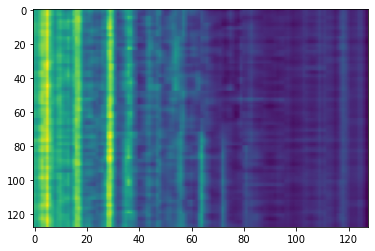

2020-11-06 14:52:15,576 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:7.960646, valid_AUC:0.671493, valid_pAUC:0.542611
100%|██████████| 832/832 [00:04<00:00, 171.69it/s]
2020-11-06 14:53:03,979 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:7.882986, valid_AUC:0.443501, valid_pAUC:0.488274
100%|██████████| 832/832 [00:04<00:00, 171.31it/s]
2020-11-06 14:53:52,368 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:8.198892, valid_AUC:0.646771, valid_pAUC:0.527504
100%|██████████| 832/832 [00:04<00:00, 172.00it/s]
2020-11-06 14:54:40,724 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:7.804663, valid_AUC:0.668669, valid_pAUC:0.535666
100%|██████████| 832/832 [00:04<00:00, 171.62it/s]
2020-11-06 14:55:29,126 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:7.759127, valid_AUC:0.668252, valid_pAUC:0.537220
100%|██████████| 832/832 [00:04<00:00, 172.02it/s]
2020-11-06 14:56:17,482 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:7.658234, valid_AUC:0.65542

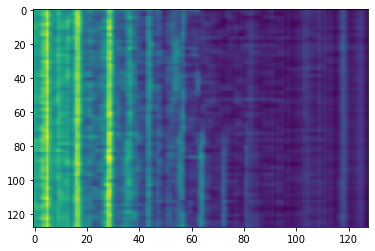

2020-11-06 15:00:19,451 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:7.429781, valid_AUC:0.661175, valid_pAUC:0.525463
2020-11-06 15:00:19,597 - 00_train.py - INFO - 
 success:pump 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/seq2seq/models/pump_model.pth


elapsed time: 4897.140687227 [sec]


2020-11-06 15:00:19,828 - 00_train.py - INFO - TARGET MACHINE_TYPE: slider
2020-11-06 15:00:19,828 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-06 15:00:19,830 - 00_train.py - INFO - TRAINING
  0%|          | 0/81 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 1246/1246 [00:07<00:00, 172.12it/s]


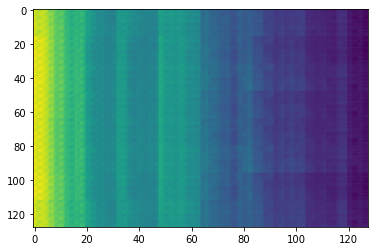

2020-11-06 15:01:06,598 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:1010.455300, valid_AUC:0.239900, valid_pAUC:0.479408
100%|██████████| 1246/1246 [00:07<00:00, 171.25it/s]
2020-11-06 15:01:52,959 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:950.308445, valid_AUC:0.241628, valid_pAUC:0.479517
100%|██████████| 1246/1246 [00:07<00:00, 172.39it/s]
2020-11-06 15:02:39,227 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:894.683295, valid_AUC:0.249164, valid_pAUC:0.479874
100%|██████████| 1246/1246 [00:07<00:00, 172.52it/s]
2020-11-06 15:03:25,537 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:842.686801, valid_AUC:0.251642, valid_pAUC:0.479890
100%|██████████| 1246/1246 [00:07<00:00, 172.27it/s]
2020-11-06 15:04:11,944 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:793.969769, valid_AUC:0.255053, valid_pAUC:0.480139
100%|██████████| 1246/1246 [00:07<00:00, 172.48it/s]
2020-11-06 15:04:58,231 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:747.994786, 

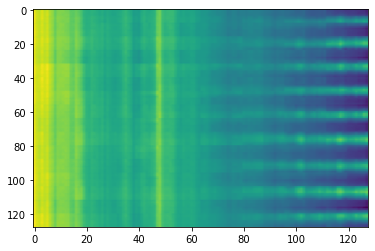

2020-11-06 15:08:03,848 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:588.047112, valid_AUC:0.325423, valid_pAUC:0.483638
100%|██████████| 1246/1246 [00:07<00:00, 172.02it/s]
2020-11-06 15:08:50,162 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:553.146034, valid_AUC:0.313821, valid_pAUC:0.482658
100%|██████████| 1246/1246 [00:07<00:00, 172.36it/s]
2020-11-06 15:09:36,438 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:520.030095, valid_AUC:0.738126, valid_pAUC:0.603755
100%|██████████| 1246/1246 [00:07<00:00, 172.44it/s]
2020-11-06 15:10:22,719 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:489.140793, valid_AUC:0.409604, valid_pAUC:0.485225
100%|██████████| 1246/1246 [00:07<00:00, 172.32it/s]
2020-11-06 15:11:09,037 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:459.017430, valid_AUC:0.534326, valid_pAUC:0.517295
100%|██████████| 1246/1246 [00:07<00:00, 172.33it/s]
2020-11-06 15:11:55,337 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:430.454

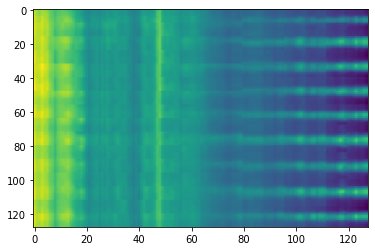

2020-11-06 15:15:47,007 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:308.833700, valid_AUC:0.602030, valid_pAUC:0.559553
100%|██████████| 1246/1246 [00:07<00:00, 171.61it/s]
2020-11-06 15:16:33,297 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:287.468453, valid_AUC:0.679746, valid_pAUC:0.650554
100%|██████████| 1246/1246 [00:07<00:00, 171.38it/s]
2020-11-06 15:17:19,603 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:267.008956, valid_AUC:0.614309, valid_pAUC:0.590674
100%|██████████| 1246/1246 [00:07<00:00, 171.54it/s]
2020-11-06 15:18:05,953 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:247.910254, valid_AUC:0.779205, valid_pAUC:0.711848
100%|██████████| 1246/1246 [00:07<00:00, 171.85it/s]
2020-11-06 15:18:52,273 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:229.948969, valid_AUC:0.721256, valid_pAUC:0.643819
100%|██████████| 1246/1246 [00:07<00:00, 171.58it/s]
2020-11-06 15:19:38,545 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:212.992

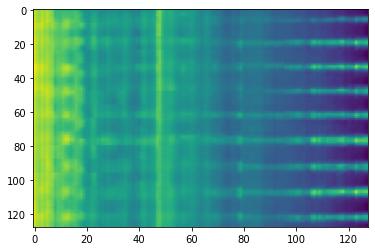

2020-11-06 15:23:30,149 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:141.724565, valid_AUC:0.680163, valid_pAUC:0.612573
100%|██████████| 1246/1246 [00:07<00:00, 172.44it/s]
2020-11-06 15:24:16,376 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:129.888236, valid_AUC:0.588528, valid_pAUC:0.544668
100%|██████████| 1246/1246 [00:07<00:00, 172.21it/s]
2020-11-06 15:25:02,645 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:118.913275, valid_AUC:0.733945, valid_pAUC:0.615404
100%|██████████| 1246/1246 [00:07<00:00, 168.60it/s]
2020-11-06 15:25:49,069 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:108.601395, valid_AUC:0.649075, valid_pAUC:0.589135
100%|██████████| 1246/1246 [00:07<00:00, 172.57it/s]
2020-11-06 15:26:35,320 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:99.041831, valid_AUC:0.594403, valid_pAUC:0.542460
100%|██████████| 1246/1246 [00:07<00:00, 172.29it/s]
2020-11-06 15:27:21,594 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:90.13523

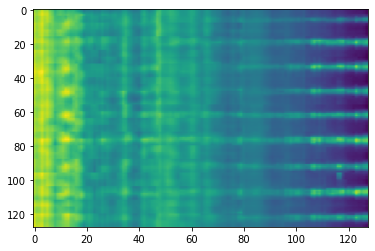

2020-11-06 15:31:13,093 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:54.704733, valid_AUC:0.789539, valid_pAUC:0.650445
100%|██████████| 1246/1246 [00:07<00:00, 171.82it/s]
2020-11-06 15:31:59,416 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:49.291027, valid_AUC:0.810241, valid_pAUC:0.666433
100%|██████████| 1246/1246 [00:07<00:00, 171.95it/s]
2020-11-06 15:32:45,709 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:44.503217, valid_AUC:0.770913, valid_pAUC:0.583022
100%|██████████| 1246/1246 [00:07<00:00, 172.31it/s]
2020-11-06 15:33:31,979 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:40.258746, valid_AUC:0.845771, valid_pAUC:0.681598
100%|██████████| 1246/1246 [00:07<00:00, 172.19it/s]
2020-11-06 15:34:18,304 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:35.870838, valid_AUC:0.849065, valid_pAUC:0.693923
100%|██████████| 1246/1246 [00:07<00:00, 172.05it/s]
2020-11-06 15:35:04,603 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:32.200959, v

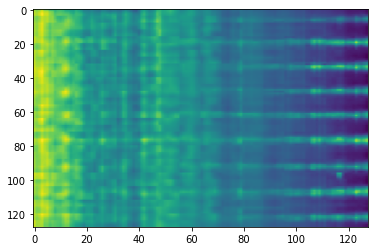

2020-11-06 15:38:56,207 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:19.044854, valid_AUC:0.715387, valid_pAUC:0.583193
100%|██████████| 1246/1246 [00:07<00:00, 168.70it/s]
2020-11-06 15:39:42,662 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:17.273713, valid_AUC:0.784353, valid_pAUC:0.605294
100%|██████████| 1246/1246 [00:07<00:00, 172.05it/s]
2020-11-06 15:40:28,967 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:16.015550, valid_AUC:0.867813, valid_pAUC:0.728226
100%|██████████| 1246/1246 [00:07<00:00, 172.10it/s]
2020-11-06 15:41:15,240 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:14.387998, valid_AUC:0.848135, valid_pAUC:0.699157
100%|██████████| 1246/1246 [00:07<00:00, 172.07it/s]
2020-11-06 15:42:01,501 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:13.241562, valid_AUC:0.823425, valid_pAUC:0.676885
100%|██████████| 1246/1246 [00:07<00:00, 171.90it/s]
2020-11-06 15:42:47,796 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:12.250129, v

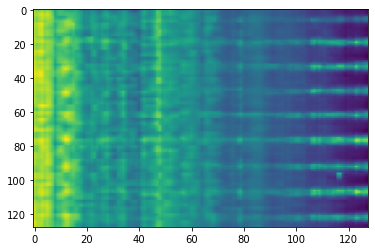

2020-11-06 15:46:39,303 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:9.183582, valid_AUC:0.822586, valid_pAUC:0.651471
100%|██████████| 1246/1246 [00:07<00:00, 172.29it/s]
2020-11-06 15:47:25,535 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:8.894563, valid_AUC:0.835163, valid_pAUC:0.662296
100%|██████████| 1246/1246 [00:07<00:00, 171.60it/s]
2020-11-06 15:48:11,978 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:8.575049, valid_AUC:0.878293, valid_pAUC:0.761719
100%|██████████| 1246/1246 [00:07<00:00, 172.17it/s]
2020-11-06 15:48:58,246 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:9.616580, valid_AUC:0.707204, valid_pAUC:0.568107
100%|██████████| 1246/1246 [00:07<00:00, 169.19it/s]
2020-11-06 15:49:44,658 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:12.239295, valid_AUC:0.768892, valid_pAUC:0.585091
100%|██████████| 1246/1246 [00:07<00:00, 172.24it/s]
2020-11-06 15:50:30,932 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:10.251713, valid

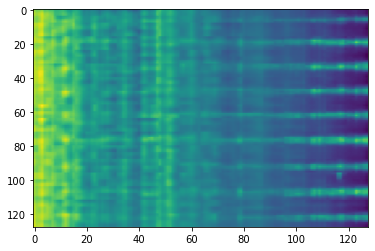

2020-11-06 15:54:22,296 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:8.311544, valid_AUC:0.844022, valid_pAUC:0.679949
100%|██████████| 1246/1246 [00:07<00:00, 171.81it/s]
2020-11-06 15:55:08,597 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:8.233576, valid_AUC:0.845464, valid_pAUC:0.690556
100%|██████████| 1246/1246 [00:07<00:00, 172.19it/s]
2020-11-06 15:55:54,848 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:8.129932, valid_AUC:0.849371, valid_pAUC:0.687710
100%|██████████| 1246/1246 [00:07<00:00, 171.95it/s]
2020-11-06 15:56:41,101 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:8.037599, valid_AUC:0.856637, valid_pAUC:0.704943
100%|██████████| 1246/1246 [00:07<00:00, 171.63it/s]
2020-11-06 15:57:27,370 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:7.913507, valid_AUC:0.854102, valid_pAUC:0.705736
100%|██████████| 1246/1246 [00:07<00:00, 172.05it/s]
2020-11-06 15:58:13,629 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:7.889820, valid_A

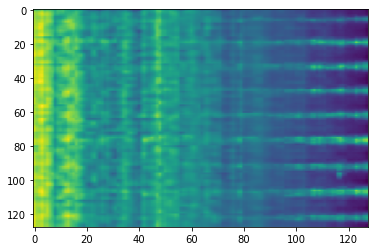

2020-11-06 16:02:05,114 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:7.559197, valid_AUC:0.843310, valid_pAUC:0.690867
100%|██████████| 1246/1246 [00:07<00:00, 171.84it/s]
2020-11-06 16:02:51,343 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:7.530367, valid_AUC:0.846987, valid_pAUC:0.701000
100%|██████████| 1246/1246 [00:07<00:00, 172.31it/s]
2020-11-06 16:03:37,575 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:7.469846, valid_AUC:0.848165, valid_pAUC:0.694227
100%|██████████| 1246/1246 [00:07<00:00, 171.92it/s]
2020-11-06 16:04:23,841 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:7.380874, valid_AUC:0.853144, valid_pAUC:0.706809
100%|██████████| 1246/1246 [00:07<00:00, 172.13it/s]
2020-11-06 16:05:10,117 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:7.313586, valid_AUC:0.852840, valid_pAUC:0.707960
100%|██████████| 1246/1246 [00:07<00:00, 172.20it/s]
2020-11-06 16:05:56,489 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:7.275024, valid_A

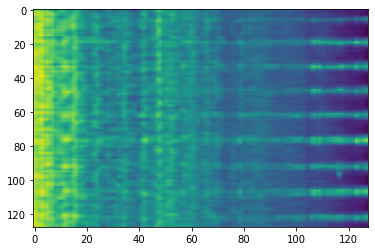

2020-11-06 16:09:47,990 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:6.919853, valid_AUC:0.847193, valid_pAUC:0.689872
100%|██████████| 1246/1246 [00:07<00:00, 172.21it/s]
2020-11-06 16:10:34,211 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:6.776584, valid_AUC:0.845706, valid_pAUC:0.696171
100%|██████████| 1246/1246 [00:07<00:00, 172.60it/s]
2020-11-06 16:11:20,418 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:6.720205, valid_AUC:0.851451, valid_pAUC:0.718396
100%|██████████| 1246/1246 [00:07<00:00, 172.20it/s]
2020-11-06 16:12:06,662 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:6.680915, valid_AUC:0.843159, valid_pAUC:0.700246
100%|██████████| 1246/1246 [00:07<00:00, 172.40it/s]
2020-11-06 16:12:52,863 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:6.579396, valid_AUC:0.831268, valid_pAUC:0.668424
100%|██████████| 1246/1246 [00:07<00:00, 172.59it/s]
2020-11-06 16:13:39,056 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:6.499326, valid_A

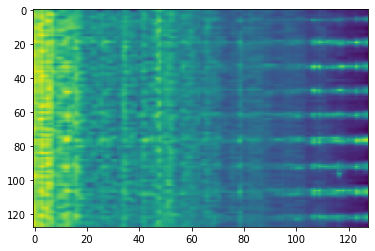

2020-11-06 16:17:30,554 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:6.295046, valid_AUC:0.843194, valid_pAUC:0.690354
2020-11-06 16:17:30,678 - 00_train.py - INFO - 
 success:slider 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/seq2seq/models/slider_model.pth


elapsed time: 4630.851820230 [sec]


2020-11-06 16:17:30,897 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyCar
2020-11-06 16:17:30,898 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-06 16:17:30,900 - 00_train.py - INFO - TRAINING
  0%|          | 0/110 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 2407/2407 [00:26<00:00, 90.65it/s]


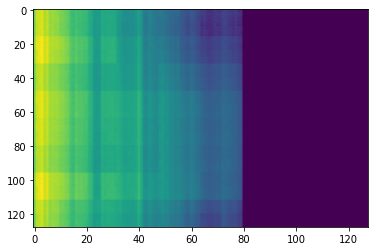

2020-11-06 16:20:00,225 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:867.533153, valid_AUC:0.434541, valid_pAUC:0.499795
100%|██████████| 2407/2407 [00:14<00:00, 171.32it/s]
2020-11-06 16:21:07,242 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:786.646993, valid_AUC:0.431293, valid_pAUC:0.499216
100%|██████████| 2407/2407 [00:14<00:00, 171.41it/s]
2020-11-06 16:22:14,442 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:714.040516, valid_AUC:0.424913, valid_pAUC:0.497588
100%|██████████| 2407/2407 [00:14<00:00, 171.63it/s]
2020-11-06 16:23:21,641 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:648.501372, valid_AUC:0.420087, valid_pAUC:0.496980
100%|██████████| 2407/2407 [00:14<00:00, 171.39it/s]
2020-11-06 16:24:28,956 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:589.102660, valid_AUC:0.415999, valid_pAUC:0.496580
100%|██████████| 2407/2407 [00:14<00:00, 171.26it/s]
2020-11-06 16:25:36,238 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:534.608089, v

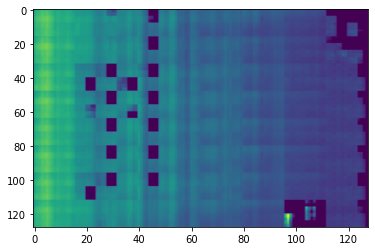

2020-11-06 16:30:05,766 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:354.652242, valid_AUC:0.462331, valid_pAUC:0.492907
100%|██████████| 2407/2407 [00:14<00:00, 171.10it/s]
2020-11-06 16:31:13,013 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:323.582708, valid_AUC:0.460505, valid_pAUC:0.501251
100%|██████████| 2407/2407 [00:14<00:00, 171.02it/s]
2020-11-06 16:32:20,298 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:289.399481, valid_AUC:0.523142, valid_pAUC:0.506813
100%|██████████| 2407/2407 [00:14<00:00, 171.27it/s]
2020-11-06 16:33:27,563 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:260.002635, valid_AUC:0.510748, valid_pAUC:0.506585
100%|██████████| 2407/2407 [00:14<00:00, 170.67it/s]
2020-11-06 16:34:34,913 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:233.371320, valid_AUC:0.487688, valid_pAUC:0.511857
100%|██████████| 2407/2407 [00:14<00:00, 169.24it/s]
2020-11-06 16:35:42,340 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:208.819

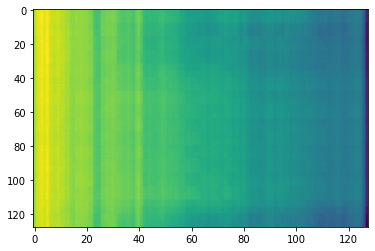

2020-11-06 16:41:18,843 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:117.736209, valid_AUC:0.581215, valid_pAUC:0.521757
100%|██████████| 2407/2407 [00:14<00:00, 171.72it/s]
2020-11-06 16:42:26,121 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:103.680604, valid_AUC:0.549200, valid_pAUC:0.530060
100%|██████████| 2407/2407 [00:14<00:00, 171.40it/s]
2020-11-06 16:43:33,378 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:90.595132, valid_AUC:0.625866, valid_pAUC:0.554961
100%|██████████| 2407/2407 [00:14<00:00, 171.78it/s]
2020-11-06 16:44:40,675 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:79.171788, valid_AUC:0.717297, valid_pAUC:0.577409
100%|██████████| 2407/2407 [00:14<00:00, 169.25it/s]
2020-11-06 16:45:48,164 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:69.126409, valid_AUC:0.627087, valid_pAUC:0.552874
100%|██████████| 2407/2407 [00:14<00:00, 171.32it/s]
2020-11-06 16:46:55,496 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:60.231517,

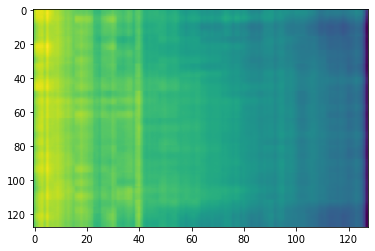

2020-11-06 16:52:31,963 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:29.966132, valid_AUC:0.622191, valid_pAUC:0.542421
100%|██████████| 2407/2407 [00:14<00:00, 171.34it/s]
2020-11-06 16:53:39,185 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:26.268417, valid_AUC:0.632145, valid_pAUC:0.544011
100%|██████████| 2407/2407 [00:14<00:00, 171.47it/s]
2020-11-06 16:54:46,439 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:22.979093, valid_AUC:0.641477, valid_pAUC:0.537056
100%|██████████| 2407/2407 [00:14<00:00, 169.93it/s]
2020-11-06 16:55:53,824 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:20.337135, valid_AUC:0.615309, valid_pAUC:0.538259
100%|██████████| 2407/2407 [00:14<00:00, 171.72it/s]
2020-11-06 16:57:01,004 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:18.149827, valid_AUC:0.617563, valid_pAUC:0.537941
100%|██████████| 2407/2407 [00:14<00:00, 171.77it/s]
2020-11-06 16:58:08,168 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:16.333853, v

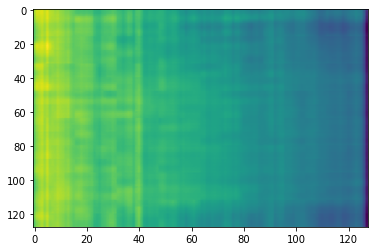

2020-11-06 17:03:44,861 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:11.569615, valid_AUC:0.645781, valid_pAUC:0.545714
100%|██████████| 2407/2407 [00:14<00:00, 171.49it/s]
2020-11-06 17:04:52,168 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:11.115400, valid_AUC:0.653846, valid_pAUC:0.547207
100%|██████████| 2407/2407 [00:14<00:00, 171.44it/s]
2020-11-06 17:05:59,464 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:10.641988, valid_AUC:0.642368, valid_pAUC:0.548275
100%|██████████| 2407/2407 [00:14<00:00, 170.90it/s]
2020-11-06 17:07:06,780 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:10.252343, valid_AUC:0.663301, valid_pAUC:0.550608
100%|██████████| 2407/2407 [00:14<00:00, 171.00it/s]
2020-11-06 17:08:14,041 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:9.922680, valid_AUC:0.669225, valid_pAUC:0.553147
100%|██████████| 2407/2407 [00:14<00:00, 171.38it/s]
2020-11-06 17:09:21,310 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:9.727303, val

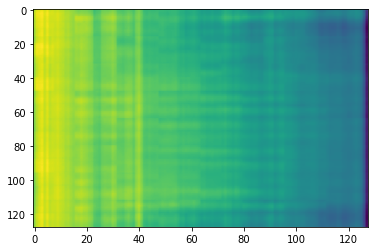

2020-11-06 17:14:58,069 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:11.082661, valid_AUC:0.658884, valid_pAUC:0.550940
100%|██████████| 2407/2407 [00:13<00:00, 171.99it/s]
2020-11-06 17:16:05,307 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:10.669881, valid_AUC:0.674624, valid_pAUC:0.551034
100%|██████████| 2407/2407 [00:14<00:00, 171.44it/s]
2020-11-06 17:17:12,521 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:10.339577, valid_AUC:0.676726, valid_pAUC:0.551131
100%|██████████| 2407/2407 [00:14<00:00, 171.77it/s]
2020-11-06 17:18:19,809 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:10.105672, valid_AUC:0.676481, valid_pAUC:0.555544
100%|██████████| 2407/2407 [00:14<00:00, 171.67it/s]
2020-11-06 17:19:27,101 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:9.929410, valid_AUC:0.667252, valid_pAUC:0.552658
100%|██████████| 2407/2407 [00:14<00:00, 170.82it/s]
2020-11-06 17:20:34,461 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:9.839097, val

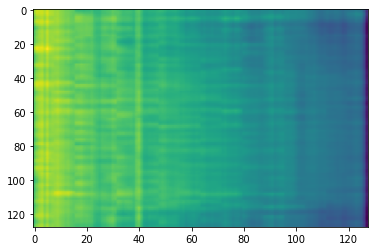

2020-11-06 17:26:11,053 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:9.425409, valid_AUC:0.680999, valid_pAUC:0.557164
100%|██████████| 2407/2407 [00:14<00:00, 171.47it/s]
2020-11-06 17:27:18,274 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:9.373669, valid_AUC:0.679682, valid_pAUC:0.549193
100%|██████████| 2407/2407 [00:14<00:00, 171.63it/s]
2020-11-06 17:28:25,592 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:9.345372, valid_AUC:0.679422, valid_pAUC:0.556768
100%|██████████| 2407/2407 [00:13<00:00, 172.10it/s]
2020-11-06 17:29:32,764 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:9.265384, valid_AUC:0.681200, valid_pAUC:0.560397
100%|██████████| 2407/2407 [00:14<00:00, 171.68it/s]
2020-11-06 17:30:40,178 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:9.161721, valid_AUC:0.685440, valid_pAUC:0.560186
100%|██████████| 2407/2407 [00:14<00:00, 169.40it/s]
2020-11-06 17:31:47,605 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:9.073314, valid_A

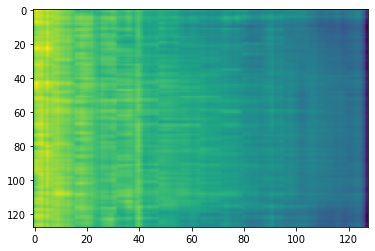

2020-11-06 17:37:23,749 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:8.650119, valid_AUC:0.666268, valid_pAUC:0.553822
100%|██████████| 2407/2407 [00:14<00:00, 171.47it/s]
2020-11-06 17:38:30,995 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:8.551958, valid_AUC:0.671248, valid_pAUC:0.550477
100%|██████████| 2407/2407 [00:14<00:00, 171.89it/s]
2020-11-06 17:39:38,245 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:8.482273, valid_AUC:0.670501, valid_pAUC:0.548066
100%|██████████| 2407/2407 [00:14<00:00, 171.67it/s]
2020-11-06 17:40:45,545 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:8.469702, valid_AUC:0.681917, valid_pAUC:0.553042
100%|██████████| 2407/2407 [00:14<00:00, 169.85it/s]
2020-11-06 17:41:52,959 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:11.484062, valid_AUC:0.619459, valid_pAUC:0.541648
100%|██████████| 2407/2407 [00:14<00:00, 171.78it/s]
2020-11-06 17:43:00,176 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:10.383430, valid

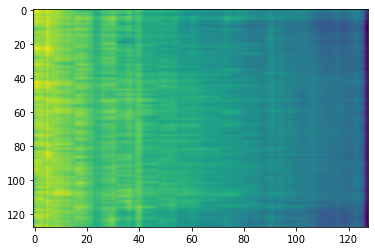

2020-11-06 17:48:36,672 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:8.652426, valid_AUC:0.696890, valid_pAUC:0.565732
100%|██████████| 2407/2407 [00:14<00:00, 169.46it/s]
2020-11-06 17:49:44,116 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:8.582876, valid_AUC:0.702721, valid_pAUC:0.559023
100%|██████████| 2407/2407 [00:14<00:00, 171.91it/s]
2020-11-06 17:50:51,318 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:8.543531, valid_AUC:0.667557, valid_pAUC:0.556152
100%|██████████| 2407/2407 [00:14<00:00, 171.31it/s]
2020-11-06 17:51:58,565 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:8.499148, valid_AUC:0.686742, valid_pAUC:0.566811
100%|██████████| 2407/2407 [00:14<00:00, 171.35it/s]
2020-11-06 17:53:05,793 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:8.448450, valid_AUC:0.679950, valid_pAUC:0.563115
100%|██████████| 2407/2407 [00:14<00:00, 171.18it/s]
2020-11-06 17:54:13,103 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:8.381635, valid_A

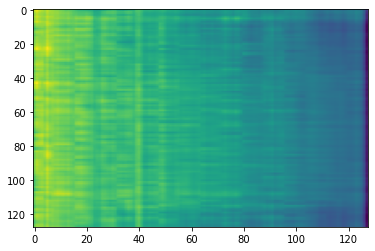

2020-11-06 17:59:49,730 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:8.245035, valid_AUC:0.680970, valid_pAUC:0.558019
100%|██████████| 2407/2407 [00:14<00:00, 170.88it/s]
2020-11-06 18:00:57,040 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:8.218886, valid_AUC:0.682790, valid_pAUC:0.566049
100%|██████████| 2407/2407 [00:14<00:00, 171.39it/s]
2020-11-06 18:02:04,318 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:8.196240, valid_AUC:0.694388, valid_pAUC:0.565784
100%|██████████| 2407/2407 [00:14<00:00, 171.25it/s]
2020-11-06 18:03:11,630 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:8.194678, valid_AUC:0.682028, valid_pAUC:0.561375
100%|██████████| 2407/2407 [00:14<00:00, 171.07it/s]
2020-11-06 18:04:18,897 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:8.144113, valid_AUC:0.654440, valid_pAUC:0.558034
100%|██████████| 2407/2407 [00:14<00:00, 171.24it/s]
2020-11-06 18:05:26,193 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:8.091497, valid_A

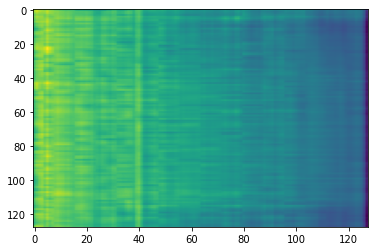

2020-11-06 18:11:02,906 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:7.751233, valid_AUC:0.651412, valid_pAUC:0.539296
2020-11-06 18:11:03,031 - 00_train.py - INFO - 
 success:ToyCar 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/seq2seq/models/ToyCar_model.pth


elapsed time: 6812.134627581 [sec]


2020-11-06 18:11:03,252 - 00_train.py - INFO - TARGET MACHINE_TYPE: ToyConveyor
2020-11-06 18:11:03,253 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-06 18:11:03,255 - 00_train.py - INFO - TRAINING
  0%|          | 0/94 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 3452/3452 [00:35<00:00, 96.31it/s] 


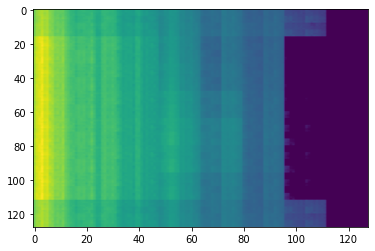

2020-11-06 18:13:22,239 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:523.358733, valid_AUC:0.467780, valid_pAUC:0.496838
100%|██████████| 3452/3452 [00:20<00:00, 171.94it/s]
2020-11-06 18:14:27,393 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:462.589978, valid_AUC:0.468505, valid_pAUC:0.497382
100%|██████████| 3452/3452 [00:20<00:00, 172.12it/s]
2020-11-06 18:15:32,627 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:411.397745, valid_AUC:0.469851, valid_pAUC:0.497893
100%|██████████| 3452/3452 [00:20<00:00, 172.23it/s]
2020-11-06 18:16:37,942 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:364.459330, valid_AUC:0.468868, valid_pAUC:0.498036
100%|██████████| 3452/3452 [00:20<00:00, 170.74it/s]
2020-11-06 18:17:43,436 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:322.246590, valid_AUC:0.467973, valid_pAUC:0.497087
100%|██████████| 3452/3452 [00:20<00:00, 172.27it/s]
2020-11-06 18:18:48,731 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:284.466813, v

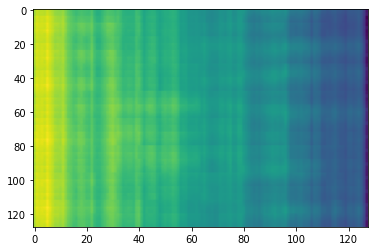

2020-11-06 18:23:10,256 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:169.429300, valid_AUC:0.469949, valid_pAUC:0.496318
100%|██████████| 3452/3452 [00:20<00:00, 169.88it/s]
2020-11-06 18:24:15,906 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:147.970481, valid_AUC:0.472733, valid_pAUC:0.498014
100%|██████████| 3452/3452 [00:20<00:00, 170.86it/s]
2020-11-06 18:25:21,317 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:129.057623, valid_AUC:0.483081, valid_pAUC:0.499482
100%|██████████| 3452/3452 [00:20<00:00, 171.28it/s]
2020-11-06 18:26:26,817 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:112.370598, valid_AUC:0.475943, valid_pAUC:0.498991
100%|██████████| 3452/3452 [00:20<00:00, 171.28it/s]
2020-11-06 18:27:32,173 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:97.759103, valid_AUC:0.486853, valid_pAUC:0.500257
100%|██████████| 3452/3452 [00:20<00:00, 171.07it/s]
2020-11-06 18:28:37,570 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:84.91859

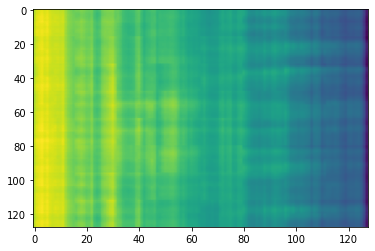

2020-11-06 18:34:05,098 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:42.459961, valid_AUC:0.531071, valid_pAUC:0.510999
100%|██████████| 3452/3452 [00:20<00:00, 170.73it/s]
2020-11-06 18:35:10,524 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:36.759802, valid_AUC:0.549346, valid_pAUC:0.518941
100%|██████████| 3452/3452 [00:20<00:00, 170.86it/s]
2020-11-06 18:36:15,939 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:32.028638, valid_AUC:0.602203, valid_pAUC:0.532221
100%|██████████| 3452/3452 [00:20<00:00, 171.09it/s]
2020-11-06 18:37:21,327 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:27.912263, valid_AUC:0.588597, valid_pAUC:0.532315
100%|██████████| 3452/3452 [00:20<00:00, 171.13it/s]
2020-11-06 18:38:26,826 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:24.575082, valid_AUC:0.563918, valid_pAUC:0.530021
100%|██████████| 3452/3452 [00:20<00:00, 170.75it/s]
2020-11-06 18:39:32,198 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:21.681894, v

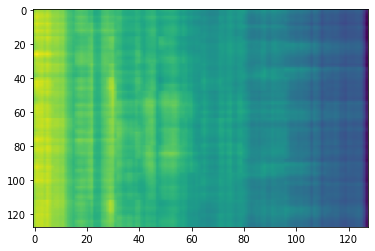

2020-11-06 18:44:59,493 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:13.335693, valid_AUC:0.602112, valid_pAUC:0.538254
100%|██████████| 3452/3452 [00:20<00:00, 170.90it/s]
2020-11-06 18:46:04,865 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:12.442788, valid_AUC:0.632197, valid_pAUC:0.518139
100%|██████████| 3452/3452 [00:20<00:00, 170.96it/s]
2020-11-06 18:47:10,184 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:11.781195, valid_AUC:0.604711, valid_pAUC:0.540433
100%|██████████| 3452/3452 [00:20<00:00, 171.02it/s]
2020-11-06 18:48:15,547 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:11.296665, valid_AUC:0.613793, valid_pAUC:0.524338
100%|██████████| 3452/3452 [00:20<00:00, 170.69it/s]
2020-11-06 18:49:20,917 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:10.915256, valid_AUC:0.613660, valid_pAUC:0.526196
100%|██████████| 3452/3452 [00:20<00:00, 171.25it/s]
2020-11-06 18:50:26,356 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:10.578450, v

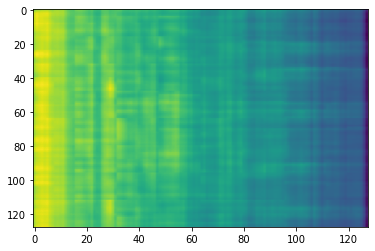

2020-11-06 18:55:53,763 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:9.643324, valid_AUC:0.627903, valid_pAUC:0.531437
100%|██████████| 3452/3452 [00:20<00:00, 171.45it/s]
2020-11-06 18:56:59,052 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:9.566095, valid_AUC:0.606622, valid_pAUC:0.529137
100%|██████████| 3452/3452 [00:20<00:00, 171.12it/s]
2020-11-06 18:58:04,410 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:9.395351, valid_AUC:0.627152, valid_pAUC:0.527190
100%|██████████| 3452/3452 [00:20<00:00, 170.80it/s]
2020-11-06 18:59:09,768 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:9.302593, valid_AUC:0.622695, valid_pAUC:0.533081
100%|██████████| 3452/3452 [00:20<00:00, 171.02it/s]
2020-11-06 19:00:15,248 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:9.317176, valid_AUC:0.613187, valid_pAUC:0.534358
100%|██████████| 3452/3452 [00:20<00:00, 171.18it/s]
2020-11-06 19:01:20,544 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:9.193045, valid_A

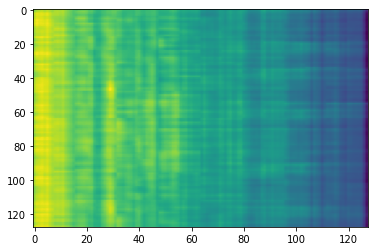

2020-11-06 19:06:47,389 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:9.163846, valid_AUC:0.625565, valid_pAUC:0.541429
100%|██████████| 3452/3452 [00:20<00:00, 169.55it/s]
2020-11-06 19:07:52,883 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:8.799601, valid_AUC:0.647129, valid_pAUC:0.551977
100%|██████████| 3452/3452 [00:20<00:00, 171.18it/s]
2020-11-06 19:08:58,229 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:8.689626, valid_AUC:0.627374, valid_pAUC:0.550402
100%|██████████| 3452/3452 [00:20<00:00, 171.08it/s]
2020-11-06 19:10:03,741 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:8.612961, valid_AUC:0.638397, valid_pAUC:0.551458
100%|██████████| 3452/3452 [00:20<00:00, 171.41it/s]
2020-11-06 19:11:09,018 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:8.567516, valid_AUC:0.655323, valid_pAUC:0.554098
100%|██████████| 3452/3452 [00:20<00:00, 171.22it/s]
2020-11-06 19:12:14,366 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:8.535045, valid_A

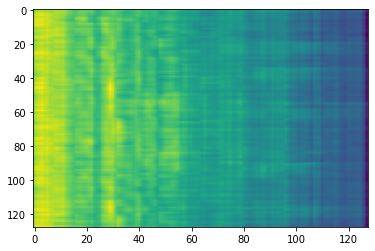

2020-11-06 19:17:41,126 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:8.276110, valid_AUC:0.645046, valid_pAUC:0.552871
100%|██████████| 3452/3452 [00:20<00:00, 171.54it/s]
2020-11-06 19:18:46,544 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:8.187538, valid_AUC:0.651192, valid_pAUC:0.556821
100%|██████████| 3452/3452 [00:20<00:00, 169.90it/s]
2020-11-06 19:19:51,972 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:8.100134, valid_AUC:0.652599, valid_pAUC:0.551474
100%|██████████| 3452/3452 [00:20<00:00, 171.51it/s]
2020-11-06 19:20:57,262 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:8.091526, valid_AUC:0.647098, valid_pAUC:0.554021
100%|██████████| 3452/3452 [00:20<00:00, 171.29it/s]
2020-11-06 19:22:02,548 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:8.019432, valid_AUC:0.635621, valid_pAUC:0.556564
100%|██████████| 3452/3452 [00:20<00:00, 171.56it/s]
2020-11-06 19:23:07,779 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:7.940658, valid_A

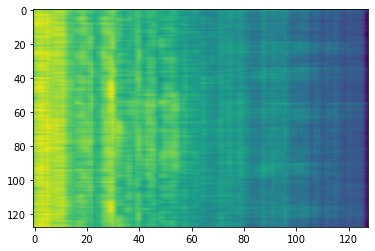

2020-11-06 19:28:34,650 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:8.103504, valid_AUC:0.638132, valid_pAUC:0.557082
100%|██████████| 3452/3452 [00:20<00:00, 171.55it/s]
2020-11-06 19:29:39,938 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:7.728163, valid_AUC:0.656277, valid_pAUC:0.556650
100%|██████████| 3452/3452 [00:20<00:00, 171.40it/s]
2020-11-06 19:30:45,224 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:7.651748, valid_AUC:0.648789, valid_pAUC:0.561001
100%|██████████| 3452/3452 [00:20<00:00, 169.92it/s]
2020-11-06 19:31:50,677 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:7.628970, valid_AUC:0.659353, valid_pAUC:0.555572
100%|██████████| 3452/3452 [00:20<00:00, 171.37it/s]
2020-11-06 19:32:55,924 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:7.549576, valid_AUC:0.661854, valid_pAUC:0.562278
100%|██████████| 3452/3452 [00:20<00:00, 169.95it/s]
2020-11-06 19:34:01,371 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:7.545481, valid_A

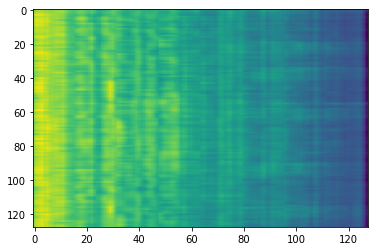

2020-11-06 19:39:27,824 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:7.370371, valid_AUC:0.645806, valid_pAUC:0.557350
100%|██████████| 3452/3452 [00:20<00:00, 171.48it/s]
2020-11-06 19:40:33,129 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:9.266407, valid_AUC:0.607660, valid_pAUC:0.529589
100%|██████████| 3452/3452 [00:20<00:00, 171.59it/s]
2020-11-06 19:41:38,385 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:8.279110, valid_AUC:0.621951, valid_pAUC:0.543205
100%|██████████| 3452/3452 [00:20<00:00, 171.38it/s]
2020-11-06 19:42:43,738 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:7.705333, valid_AUC:0.642502, valid_pAUC:0.546925
100%|██████████| 3452/3452 [00:20<00:00, 170.03it/s]
2020-11-06 19:43:49,150 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:7.552695, valid_AUC:0.638187, valid_pAUC:0.549531
100%|██████████| 3452/3452 [00:20<00:00, 171.67it/s]
2020-11-06 19:44:54,421 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:7.424002, valid_A

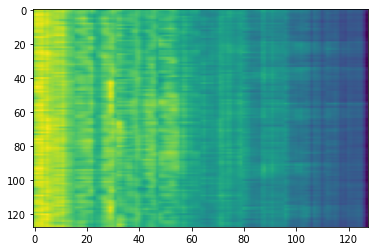

2020-11-06 19:50:21,126 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:7.158311, valid_AUC:0.654160, valid_pAUC:0.556761
100%|██████████| 3452/3452 [00:20<00:00, 171.73it/s]
2020-11-06 19:51:26,351 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:7.181666, valid_AUC:0.666317, valid_pAUC:0.559346
100%|██████████| 3452/3452 [00:20<00:00, 171.98it/s]
2020-11-06 19:52:31,607 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:7.102120, valid_AUC:0.645807, valid_pAUC:0.556506
100%|██████████| 3452/3452 [00:20<00:00, 172.11it/s]
2020-11-06 19:53:36,800 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:7.064590, valid_AUC:0.669408, valid_pAUC:0.554967
100%|██████████| 3452/3452 [00:20<00:00, 171.87it/s]
2020-11-06 19:54:42,150 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:7.080010, valid_AUC:0.660841, valid_pAUC:0.558953
100%|██████████| 3452/3452 [00:20<00:00, 170.60it/s]
2020-11-06 19:55:47,500 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:6.977647, valid_A

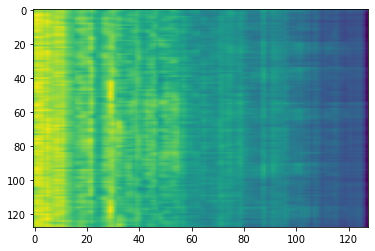

2020-11-06 20:01:14,077 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:6.885191, valid_AUC:0.663034, valid_pAUC:0.559389
2020-11-06 20:01:14,209 - 00_train.py - INFO - 
 success:ToyConveyor 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/seq2seq/models/ToyConveyor_model.pth


elapsed time: 6610.957675219 [sec]


2020-11-06 20:01:14,465 - 00_train.py - INFO - TARGET MACHINE_TYPE: valve
2020-11-06 20:01:14,466 - 00_train.py - INFO - MAKE DATA_LOADER
2020-11-06 20:01:14,468 - 00_train.py - INFO - TRAINING
  0%|          | 0/91 [00:00<?, ?it/s]

use: cuda:0


100%|██████████| 855/855 [00:08<00:00, 97.82it/s] 


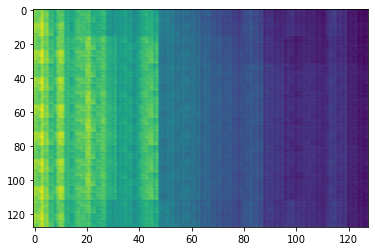

2020-11-06 20:03:02,696 - pytorch_modeler.py - INFO - Epoch 1/100:train_loss:1000.050262, valid_AUC:0.491088, valid_pAUC:0.503470
100%|██████████| 855/855 [00:04<00:00, 171.06it/s]
2020-11-06 20:03:51,573 - pytorch_modeler.py - INFO - Epoch 2/100:train_loss:932.829853, valid_AUC:0.490385, valid_pAUC:0.502834
100%|██████████| 855/855 [00:04<00:00, 171.86it/s]
2020-11-06 20:04:40,433 - pytorch_modeler.py - INFO - Epoch 3/100:train_loss:871.897163, valid_AUC:0.486148, valid_pAUC:0.503702
100%|██████████| 855/855 [00:04<00:00, 172.45it/s]
2020-11-06 20:05:29,262 - pytorch_modeler.py - INFO - Epoch 4/100:train_loss:815.495137, valid_AUC:0.487673, valid_pAUC:0.502660
100%|██████████| 855/855 [00:04<00:00, 171.73it/s]
2020-11-06 20:06:18,142 - pytorch_modeler.py - INFO - Epoch 5/100:train_loss:763.094717, valid_AUC:0.483154, valid_pAUC:0.502516
100%|██████████| 855/855 [00:04<00:00, 172.02it/s]
2020-11-06 20:07:07,024 - pytorch_modeler.py - INFO - Epoch 6/100:train_loss:712.935106, valid_AUC:

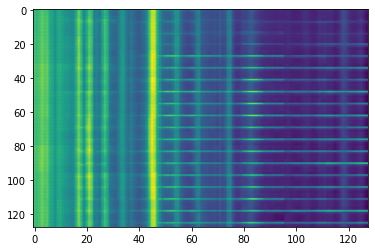

2020-11-06 20:10:22,796 - pytorch_modeler.py - INFO - Epoch 10/100:train_loss:541.743981, valid_AUC:0.481549, valid_pAUC:0.503470
100%|██████████| 855/855 [00:04<00:00, 171.96it/s]
2020-11-06 20:11:11,725 - pytorch_modeler.py - INFO - Epoch 11/100:train_loss:505.392007, valid_AUC:0.482788, valid_pAUC:0.502429
100%|██████████| 855/855 [00:04<00:00, 171.82it/s]
2020-11-06 20:12:00,915 - pytorch_modeler.py - INFO - Epoch 12/100:train_loss:471.031949, valid_AUC:0.492846, valid_pAUC:0.503355
100%|██████████| 855/855 [00:04<00:00, 171.56it/s]
2020-11-06 20:12:49,856 - pytorch_modeler.py - INFO - Epoch 13/100:train_loss:438.521947, valid_AUC:0.473382, valid_pAUC:0.503962
100%|██████████| 855/855 [00:04<00:00, 172.07it/s]
2020-11-06 20:13:38,735 - pytorch_modeler.py - INFO - Epoch 14/100:train_loss:407.829594, valid_AUC:0.469412, valid_pAUC:0.496761
100%|██████████| 855/855 [00:04<00:00, 172.00it/s]
2020-11-06 20:14:27,810 - pytorch_modeler.py - INFO - Epoch 15/100:train_loss:379.033039, valid

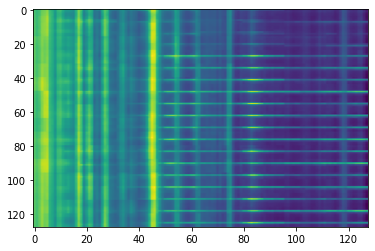

2020-11-06 20:18:32,593 - pytorch_modeler.py - INFO - Epoch 20/100:train_loss:255.463545, valid_AUC:0.517159, valid_pAUC:0.504135
100%|██████████| 855/855 [00:04<00:00, 172.30it/s]
2020-11-06 20:19:21,498 - pytorch_modeler.py - INFO - Epoch 21/100:train_loss:234.783870, valid_AUC:0.493016, valid_pAUC:0.502545
100%|██████████| 855/855 [00:04<00:00, 172.02it/s]
2020-11-06 20:20:10,464 - pytorch_modeler.py - INFO - Epoch 22/100:train_loss:215.448328, valid_AUC:0.485005, valid_pAUC:0.492944
100%|██████████| 855/855 [00:04<00:00, 172.38it/s]
2020-11-06 20:20:59,356 - pytorch_modeler.py - INFO - Epoch 23/100:train_loss:197.250614, valid_AUC:0.467907, valid_pAUC:0.494390
100%|██████████| 855/855 [00:04<00:00, 172.64it/s]
2020-11-06 20:21:48,216 - pytorch_modeler.py - INFO - Epoch 24/100:train_loss:180.227684, valid_AUC:0.520385, valid_pAUC:0.501301
100%|██████████| 855/855 [00:04<00:00, 172.00it/s]
2020-11-06 20:22:37,116 - pytorch_modeler.py - INFO - Epoch 25/100:train_loss:164.372396, valid

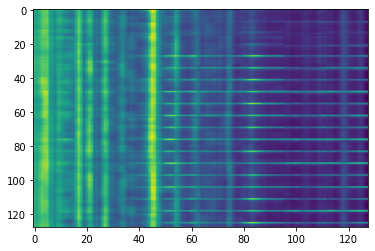

2020-11-06 20:26:41,704 - pytorch_modeler.py - INFO - Epoch 30/100:train_loss:100.150713, valid_AUC:0.510451, valid_pAUC:0.498988
100%|██████████| 855/855 [00:04<00:00, 172.33it/s]
2020-11-06 20:27:30,593 - pytorch_modeler.py - INFO - Epoch 31/100:train_loss:90.019317, valid_AUC:0.511478, valid_pAUC:0.497079
100%|██████████| 855/855 [00:04<00:00, 172.68it/s]
2020-11-06 20:28:19,631 - pytorch_modeler.py - INFO - Epoch 32/100:train_loss:80.777512, valid_AUC:0.506934, valid_pAUC:0.502082
100%|██████████| 855/855 [00:04<00:00, 171.92it/s]
2020-11-06 20:29:08,527 - pytorch_modeler.py - INFO - Epoch 33/100:train_loss:72.189581, valid_AUC:0.496148, valid_pAUC:0.495373
100%|██████████| 855/855 [00:04<00:00, 172.43it/s]
2020-11-06 20:29:57,429 - pytorch_modeler.py - INFO - Epoch 34/100:train_loss:64.432676, valid_AUC:0.522907, valid_pAUC:0.501359
100%|██████████| 855/855 [00:04<00:00, 171.25it/s]
2020-11-06 20:30:46,357 - pytorch_modeler.py - INFO - Epoch 35/100:train_loss:57.467719, valid_AUC:

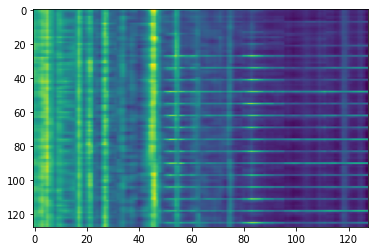

2020-11-06 20:34:51,073 - pytorch_modeler.py - INFO - Epoch 40/100:train_loss:31.229351, valid_AUC:0.498082, valid_pAUC:0.505986
100%|██████████| 855/855 [00:04<00:00, 172.67it/s]
2020-11-06 20:35:39,965 - pytorch_modeler.py - INFO - Epoch 41/100:train_loss:27.575805, valid_AUC:0.563585, valid_pAUC:0.504251
100%|██████████| 855/855 [00:04<00:00, 171.87it/s]
2020-11-06 20:36:28,887 - pytorch_modeler.py - INFO - Epoch 42/100:train_loss:24.282934, valid_AUC:0.492060, valid_pAUC:0.500665
100%|██████████| 855/855 [00:04<00:00, 171.79it/s]
2020-11-06 20:37:17,782 - pytorch_modeler.py - INFO - Epoch 43/100:train_loss:21.440779, valid_AUC:0.572549, valid_pAUC:0.497137
100%|██████████| 855/855 [00:04<00:00, 171.72it/s]
2020-11-06 20:38:06,697 - pytorch_modeler.py - INFO - Epoch 44/100:train_loss:19.072387, valid_AUC:0.491956, valid_pAUC:0.495980
100%|██████████| 855/855 [00:04<00:00, 172.48it/s]
2020-11-06 20:38:55,571 - pytorch_modeler.py - INFO - Epoch 45/100:train_loss:16.953031, valid_AUC:0

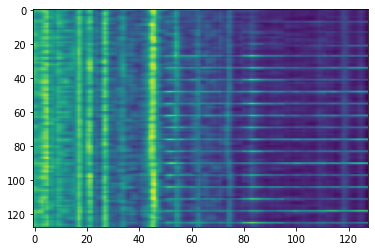

2020-11-06 20:43:00,492 - pytorch_modeler.py - INFO - Epoch 50/100:train_loss:10.006217, valid_AUC:0.552978, valid_pAUC:0.505552
100%|██████████| 855/855 [00:04<00:00, 172.26it/s]
2020-11-06 20:43:49,396 - pytorch_modeler.py - INFO - Epoch 51/100:train_loss:9.154183, valid_AUC:0.563297, valid_pAUC:0.506102
100%|██████████| 855/855 [00:04<00:00, 171.77it/s]
2020-11-06 20:44:38,332 - pytorch_modeler.py - INFO - Epoch 52/100:train_loss:8.547800, valid_AUC:0.565467, valid_pAUC:0.503557
100%|██████████| 855/855 [00:04<00:00, 172.42it/s]
2020-11-06 20:45:27,241 - pytorch_modeler.py - INFO - Epoch 53/100:train_loss:7.945569, valid_AUC:0.556077, valid_pAUC:0.503817
100%|██████████| 855/855 [00:04<00:00, 172.44it/s]
2020-11-06 20:46:16,285 - pytorch_modeler.py - INFO - Epoch 54/100:train_loss:7.428474, valid_AUC:0.575813, valid_pAUC:0.505610
100%|██████████| 855/855 [00:04<00:00, 172.51it/s]
2020-11-06 20:47:05,149 - pytorch_modeler.py - INFO - Epoch 55/100:train_loss:7.152119, valid_AUC:0.5835

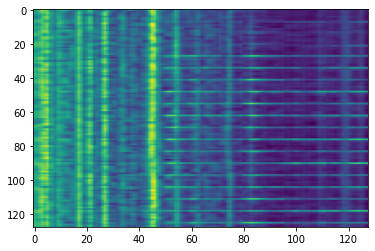

2020-11-06 20:51:09,711 - pytorch_modeler.py - INFO - Epoch 60/100:train_loss:6.099526, valid_AUC:0.550841, valid_pAUC:0.507201
100%|██████████| 855/855 [00:04<00:00, 171.59it/s]
2020-11-06 20:51:58,633 - pytorch_modeler.py - INFO - Epoch 61/100:train_loss:6.000113, valid_AUC:0.557025, valid_pAUC:0.512984
100%|██████████| 855/855 [00:04<00:00, 172.32it/s]
2020-11-06 20:52:47,511 - pytorch_modeler.py - INFO - Epoch 62/100:train_loss:5.885059, valid_AUC:0.569720, valid_pAUC:0.508444
100%|██████████| 855/855 [00:04<00:00, 172.07it/s]
2020-11-06 20:53:36,380 - pytorch_modeler.py - INFO - Epoch 63/100:train_loss:5.769163, valid_AUC:0.558791, valid_pAUC:0.505119
100%|██████████| 855/855 [00:04<00:00, 172.36it/s]
2020-11-06 20:54:25,440 - pytorch_modeler.py - INFO - Epoch 64/100:train_loss:5.693761, valid_AUC:0.562038, valid_pAUC:0.510931
100%|██████████| 855/855 [00:04<00:00, 172.34it/s]
2020-11-06 20:55:14,337 - pytorch_modeler.py - INFO - Epoch 65/100:train_loss:5.570738, valid_AUC:0.53640

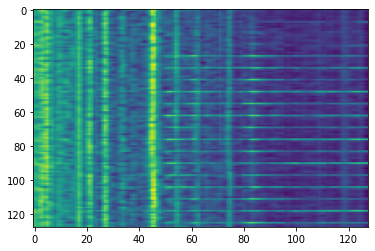

2020-11-06 20:59:18,892 - pytorch_modeler.py - INFO - Epoch 70/100:train_loss:5.301543, valid_AUC:0.566341, valid_pAUC:0.510324
100%|██████████| 855/855 [00:04<00:00, 172.17it/s]
2020-11-06 21:00:07,787 - pytorch_modeler.py - INFO - Epoch 71/100:train_loss:5.093811, valid_AUC:0.563797, valid_pAUC:0.509746
100%|██████████| 855/855 [00:04<00:00, 171.82it/s]
2020-11-06 21:00:56,677 - pytorch_modeler.py - INFO - Epoch 72/100:train_loss:5.040075, valid_AUC:0.540747, valid_pAUC:0.505176
100%|██████████| 855/855 [00:05<00:00, 164.44it/s]
2020-11-06 21:01:45,817 - pytorch_modeler.py - INFO - Epoch 73/100:train_loss:4.910342, valid_AUC:0.546445, valid_pAUC:0.508473
100%|██████████| 855/855 [00:04<00:00, 172.15it/s]
2020-11-06 21:02:34,711 - pytorch_modeler.py - INFO - Epoch 74/100:train_loss:4.837129, valid_AUC:0.559302, valid_pAUC:0.505234
100%|██████████| 855/855 [00:04<00:00, 172.03it/s]
2020-11-06 21:03:23,614 - pytorch_modeler.py - INFO - Epoch 75/100:train_loss:4.764874, valid_AUC:0.53730

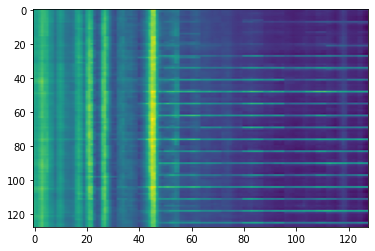

2020-11-06 21:07:28,424 - pytorch_modeler.py - INFO - Epoch 80/100:train_loss:9.229013, valid_AUC:0.475703, valid_pAUC:0.487796
100%|██████████| 855/855 [00:04<00:00, 171.88it/s]
2020-11-06 21:08:17,371 - pytorch_modeler.py - INFO - Epoch 81/100:train_loss:10.737863, valid_AUC:0.510099, valid_pAUC:0.501099
100%|██████████| 855/855 [00:04<00:00, 171.08it/s]
2020-11-06 21:09:06,343 - pytorch_modeler.py - INFO - Epoch 82/100:train_loss:9.047607, valid_AUC:0.521874, valid_pAUC:0.501215
100%|██████████| 855/855 [00:04<00:00, 172.36it/s]
2020-11-06 21:09:55,237 - pytorch_modeler.py - INFO - Epoch 83/100:train_loss:8.013467, valid_AUC:0.522846, valid_pAUC:0.500318
100%|██████████| 855/855 [00:04<00:00, 172.13it/s]
2020-11-06 21:10:44,138 - pytorch_modeler.py - INFO - Epoch 84/100:train_loss:7.186558, valid_AUC:0.508445, valid_pAUC:0.500578
100%|██████████| 855/855 [00:04<00:00, 172.09it/s]
2020-11-06 21:11:33,074 - pytorch_modeler.py - INFO - Epoch 85/100:train_loss:6.508648, valid_AUC:0.5199

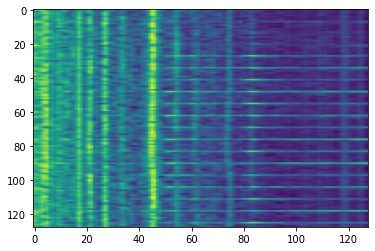

2020-11-06 21:15:37,753 - pytorch_modeler.py - INFO - Epoch 90/100:train_loss:5.057203, valid_AUC:0.527940, valid_pAUC:0.504106
100%|██████████| 855/855 [00:04<00:00, 171.78it/s]
2020-11-06 21:16:26,659 - pytorch_modeler.py - INFO - Epoch 91/100:train_loss:4.910690, valid_AUC:0.528187, valid_pAUC:0.506998
100%|██████████| 855/855 [00:04<00:00, 172.65it/s]
2020-11-06 21:17:15,499 - pytorch_modeler.py - INFO - Epoch 92/100:train_loss:4.797349, valid_AUC:0.546648, valid_pAUC:0.501475
100%|██████████| 855/855 [00:04<00:00, 172.14it/s]
2020-11-06 21:18:04,367 - pytorch_modeler.py - INFO - Epoch 93/100:train_loss:4.700178, valid_AUC:0.537005, valid_pAUC:0.503441
100%|██████████| 855/855 [00:04<00:00, 172.47it/s]
2020-11-06 21:18:53,252 - pytorch_modeler.py - INFO - Epoch 94/100:train_loss:4.619536, valid_AUC:0.534440, valid_pAUC:0.506854
100%|██████████| 855/855 [00:04<00:00, 171.26it/s]
2020-11-06 21:19:42,161 - pytorch_modeler.py - INFO - Epoch 95/100:train_loss:4.560030, valid_AUC:0.54505

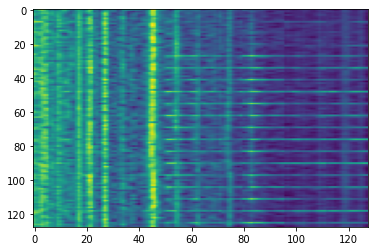

2020-11-06 21:23:47,041 - pytorch_modeler.py - INFO - Epoch 100/100:train_loss:4.168616, valid_AUC:0.543808, valid_pAUC:0.499537
2020-11-06 21:23:47,168 - 00_train.py - INFO - 
 success:valve 
model_out_path ==> 
 /media/hiroki/working/research/dcase2020/result/2D/seq2seq/models/valve_model.pth


elapsed time: 4952.703906298 [sec]


In [11]:
for machine_type in machine_types:
    history = run(machine_type)
    with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
        pickle.dump(history , file)

history = run('ToyCar')
with open('{}/{}_history.pkl'.format(PKL_DIR, machine_type), 'wb') as file:
    pickle.dump(history , file)